# Advanced Fishing

This Notebook goes through some of the slightly more advanced tasks which can be performed with `GoFish`. As with the previous Notebook we will be using the [CS (3-2) data from TW Hya](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/LO2QZM). Make sure that cube is accessible when running this Notebook.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from gofish import imagecube

In [2]:
cube = imagecube('TWHya_CS_32.fits', FOV=6.0)

## Checking Disk Center

If you don't have a strong line detection, it's hard to make sure that your image is centered. We can use the `find_center` function to apply a brute force approach to finding the optimum location. This will cycle through a grid of `x0` and `y0` values and calculate the signal-to-noise ratio (SNR) of the resulting spectrum averaged over the provided parameters.

We can set the offset in the x- and y-direction considered, `dx` and `dy`, respectively, as well as the number of samples along each axis, `Nx` and `Ny`. By default we search up to a distance of the beam FWHM, sampling roughly every pixel.

We must also then consider how to calculate the noise, either on the averaged spectrum, `spectrum='avg'`, or on the integrated spectrum, `spectrum='int'`, and then whether to consider the signal the peak of that spectrum, `SNR='peak'`, or the integrated value, `SNR='int'`. By default we use the peak flux density of the averaged spectrum.

A mask is also needed, defining the regions where we calculate the signal, and the regions where to calculate the noise (we use the standard deviation of the masked pixels). By default the mask assumes the line emission is in the center 20\% of the channels.

If you want to mask a specific range, you can use the `v_min` and `v_max` values. If your line profile is more complex, for example contains multiple transitions, you can include a user defined masked directly with the `mask` argument. Make sure that this is the same size as your expected velocity axis based on the `resample` parameter.

Note that this may take a while, particularly if you're searching a large area!

Peak SNR at (x0, y0) = (-0.06", -0.02").


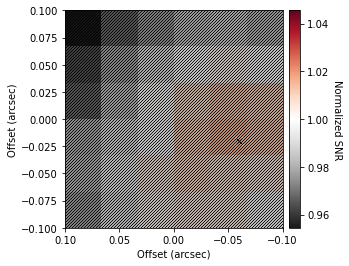

In [3]:
x0s, y0s, SNR = cube.find_center(dx=0.1, dy=0.1, r_min=0.5, r_max=1.0,
                                 v_min=1.84e3, v_max=3.84e3,
                                 SNR='peak', inc=5.0, PA=152., mstar=0.88,
                                 dist=59.5, resample=50.0)

What's plotted here is the SNR relative to the value at the image center, and in the bottom left corner, the synthesized beam as a size reference. This makes sense as the image was centered based on continuum.

Clearly the offset spectrum looks a lot better, as expected!

## Masking Regions

As demonstrated in [Yen et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016ApJ...832..204Y), this method can be applied to specfic sections of the disk, i.e. you do not have to consider the disk as a whole.

We've already seen the `r_min` and `r_max` values used in `average_spectrum` and `integrated_spectrum` which set the inner and outer radii of the annuli. But we also have `PA_min` and `PA_max`, which allow for similar masks in the azimuthal direction. The are provided in degrees, where $\theta = 0$ aligns with the red-shifted major axis of the disk, and increasing in an eastwards direction, spanning $\pm 180^{\circ}$. Thus, to only consider the red-shifted side of the disk, we use `PA_min=-90.0` and `PA_max=90.0`.

Because of the change in sign, we can access the other half of the disk through the `exclude_PA=True`, which by default is `False`.

(1840.0, 3840.0)

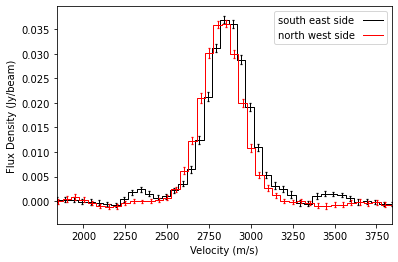

In [4]:
fig, ax = plt.subplots()

x, y, dy = cube.average_spectrum(r_min=0.5, r_max=1.5, inc=5.0, PA=152.,
                                 mstar=0.88, dist=59.5, resample=50.0,
                                 PA_min=-90.0, PA_max=90.0, exclude_PA=False)

ax.errorbar(x, y, dy, fmt=' ', lw=1.0, color='k', capsize=1.25, capthick=1.25)
ax.step(x, y, where='mid', color='k', lw=1.0, label='south east side')

x, y, dy = cube.average_spectrum(r_min=0.5, r_max=1.5, inc=5.0, PA=152.,
                                 mstar=0.88, dist=59.5, resample=50.0,
                                 PA_min=-90.0, PA_max=90.0, exclude_PA=True)

ax.errorbar(x, y, dy, fmt=' ', lw=1.0, color='r', capsize=1.25, capthick=1.25)
ax.step(x, y, where='mid', color='r', lw=1.0, label='north west side')

ax.legend(markerfirst=False)
ax.set_ylabel('Flux Density (Jy/beam)')
ax.set_xlabel('Velocity (m/s)')
ax.set_xlim(1.84e3, 3.84e3)

Note that there is some slight shift between the two lines because of beam convolution effects.

## Shifted Cube

More details coming.

In [5]:
shifted = cube.shifted_cube(inc=5.0, PA=152., mstar=0.88, dist=59.5)

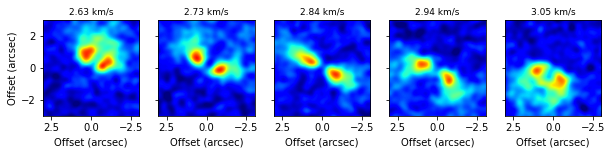

In [6]:
fig, axs = plt.subplots(ncols=5, figsize=(10, 2))

v0 = abs(cube.velax - 2.84e3).argmin()
for a, ax in enumerate(axs):
    idx = a * 3 + v0 - 6
    data = np.nanmean(cube.data[idx-1:idx+2], axis=0)
    ax.imshow(data, origin='lower', extent=cube.extent, vmin=-0.005, vmax=0.05, cmap='jet')
    if a > 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('Offset (arcsec)')
    ax.set_xlabel('Offset (arcsec)')
    ax.set_title('{:.2f} km/s'.format(cube.velax[idx] / 1e3), fontsize=9)

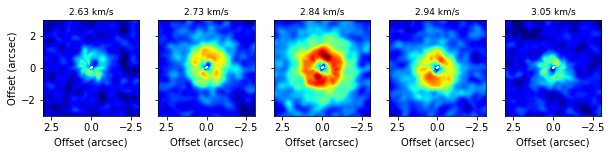

In [7]:
fig, axs = plt.subplots(ncols=5, figsize=(10, 2))

v0 = abs(cube.velax - 2.84e3).argmin()
for a, ax in enumerate(axs):
    idx = a * 3 + v0 - 6
    data = np.nanmean(shifted[idx-1:idx+2], axis=0)
    ax.imshow(data, origin='lower', extent=cube.extent, vmin=-0.005, vmax=0.05, cmap='jet')
    if a > 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('Offset (arcsec)')
    ax.set_xlabel('Offset (arcsec)')
    ax.set_title('{:.2f} km/s'.format(cube.velax[idx] / 1e3), fontsize=9)